In [1]:
pip install kagglehub

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import kagglehub

In [3]:
print("Downloading dataset from KaggleHub...")
dataset_path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print("Dataset downloaded to:", dataset_path)

Dataset downloaded to: /kaggle/input/gtsrb-german-traffic-sign


In [4]:
train_path = os.path.join(dataset_path, "train")
test_csv_path = os.path.join(dataset_path, "Test.csv")

In [5]:
image_size = 30
num_classes = 43
epochs = 30
batch_size = 32

data = []
labels = []

print("Loading training data...")

for i in range(num_classes):
    class_path = os.path.join(train_path, str(i))
    if not os.path.exists(class_path):
        print(f"Warning: {class_path} not found.")
        continue

    images = os.listdir(class_path)
    for img_name in images:
        try:
            img_path = os.path.join(class_path, img_name)
            image = Image.open(img_path)
            image = image.resize((image_size, image_size))
            data.append(np.array(image))
            labels.append(i)
        except:
            print(f"Error loading image: {img_name}")

Loading training data...


In [6]:
data = np.array(data) / 255.0
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    fill_mode="nearest")
datagen.fit(X_train)

In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5)

history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),epochs=epochs,validation_data=(X_test, y_test),callbacks=[early_stop, reduce_lr])


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.2830 - loss: 2.8673 - val_accuracy: 0.7898 - val_loss: 0.6078 - learning_rate: 0.0010
Epoch 2/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.7142 - loss: 0.8761 - val_accuracy: 0.9589 - val_loss: 0.1283 - learning_rate: 0.0010
Epoch 3/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.8486 - loss: 0.4731 - val_accuracy: 0.9830 - val_loss: 0.0621 - learning_rate: 0.0010
Epoch 4/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9017 - loss: 0.3196 - val_accuracy: 0.9908 - val_loss: 0.0427 - learning_rate: 0.0010
Epoch 5/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9292 - loss: 0.2275 - val_accuracy: 0.9916 - val_loss: 0.0262 - learning_rate: 0.0010
Epoch 6/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9452 - loss: 0.1826 - val_accuracy: 0.9930 - val_loss: 0.0217 - learning_rate: 0.0010
Epoch 7/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9485 - loss: 0.1747

In [9]:
model.save('TSR.keras')

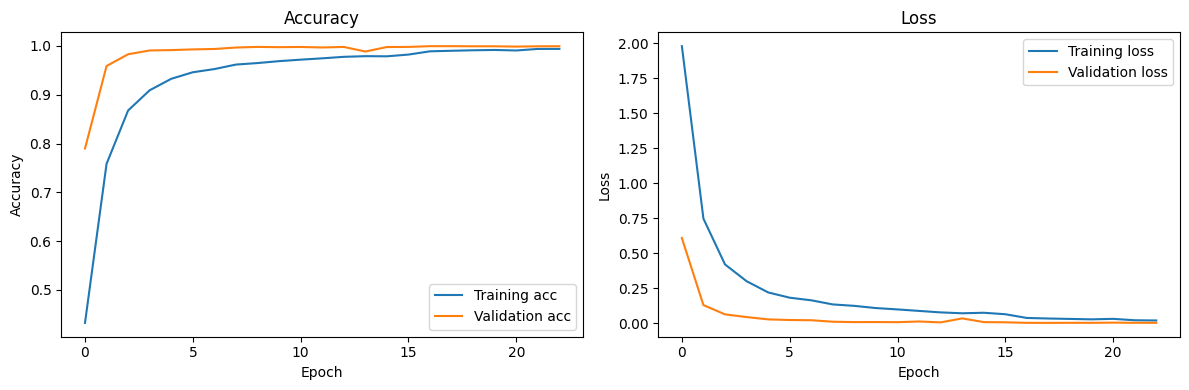

In [10]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
print("Evaluating on external test set...")

test_df = pd.read_csv(test_csv_path)
labels = test_df["ClassId"].values
paths = test_df["Path"].values

test_data = []
for rel_path in paths:
    full_path = os.path.join(dataset_path, rel_path.strip())
    image = Image.open(full_path)
    image = image.resize((image_size, image_size))
    test_data.append(np.array(image))

X_test_external = np.array(test_data) / 255.0
pred_probs = model.predict(X_test_external)
pred = np.argmax(pred_probs, axis=1)

print("External Test Accuracy:", accuracy_score(labels, pred))

Evaluating on external test set...
395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
External Test Accuracy: 0.9859857482185274


In [14]:
classes = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing for vehicles over 3.5 tons',
    11: 'Right-of-way at intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Vehicles > 3.5 tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve left',
    20: 'Dangerous curve right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End of all speed and passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End no passing vehicles > 3.5 tons'
}


In [15]:
pred = np.argmax(pred_probs, axis=1)


In [16]:
for i in range(10):
    print(f"Image {i}: Predicted = {pred[i]} ({classes[pred[i]]}), Actual = {labels[i]} ({classes[labels[i]]})")


Image 0: Predicted = 16 (Vehicles > 3.5 tons prohibited), Actual = 16 (Vehicles > 3.5 tons prohibited)
Image 1: Predicted = 1 (Speed limit (30km/h)), Actual = 1 (Speed limit (30km/h))
Image 2: Predicted = 38 (Keep right), Actual = 38 (Keep right)
Image 3: Predicted = 33 (Turn right ahead), Actual = 33 (Turn right ahead)
Image 4: Predicted = 11 (Right-of-way at intersection), Actual = 11 (Right-of-way at intersection)
Image 5: Predicted = 38 (Keep right), Actual = 38 (Keep right)
Image 6: Predicted = 18 (General caution), Actual = 18 (General caution)
Image 7: Predicted = 12 (Priority road), Actual = 12 (Priority road)
Image 8: Predicted = 25 (Road work), Actual = 25 (Road work)
Image 9: Predicted = 35 (Ahead only), Actual = 35 (Ahead only)


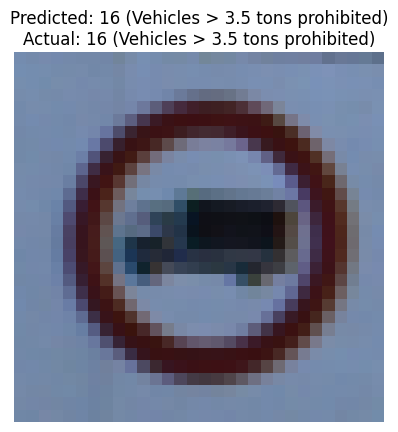

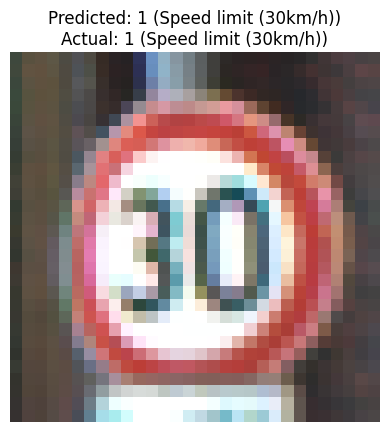

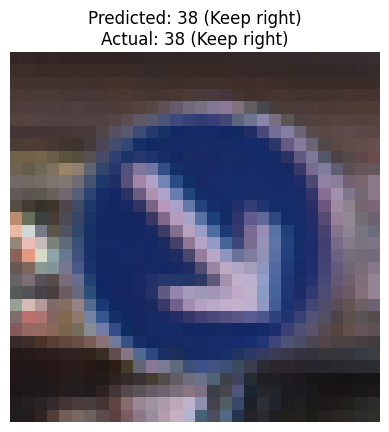

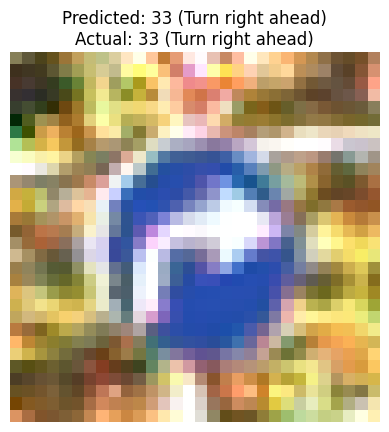

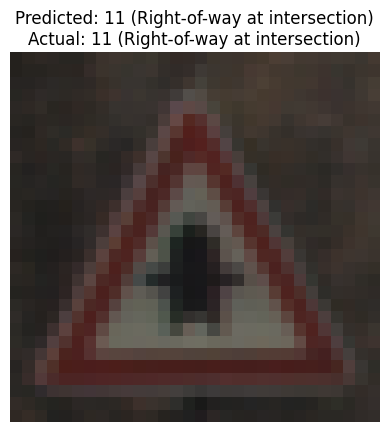

In [17]:
for i in range(5):
    plt.imshow(X_test_external[i])
    pred_label = pred[i]
    true_label = labels[i]

    pred_name = classes[pred_label]
    true_name = classes[true_label]

    plt.title(f"Predicted: {pred_label} ({pred_name})\nActual: {true_label} ({true_name})")
    plt.axis('off')
    plt.show()
